# Latent Variable Implementation

The `gp.Latent` class is a direct implementation of a Gaussian process without approximation.  Given a mean and covariance function, we can place a prior on the function $f(x)$,

$$
f(x) \sim \mathcal{GP}(m(x),\, k(x, x')) \,.
$$

It is called "Latent" because the GP itself is included in the model as a latent variable, it is not marginalized out as is the case with `gp.Marginal`. 

## The `.prior` method

The `prior` method adds a multivariate normal prior distribution to the PyMC model over the vector of GP function values, $\mathbf{f}$,

$$
\mathbf{f} \sim \text{MvNormal}(\mathbf{m}_{x},\, \mathbf{K}_{xx}) \,,
$$

where the vector $\mathbf{m}_x$ and the matrix $\mathbf{K}_{xx}$ are the mean vector and covariance matrix evaluated over the inputs $x$.  Some sample code is,

```python
import numpy as np
import pymc3 as pm

# A one dimensional column vector of inputs.
X = np.linspace(0, 1, 10)[:,None]

with pm.Model() as latent_gp_model:
    # Specify the covariance function.
    cov_func = pm.gp.cov.ExpQuad(1, ls=0.1)
    
    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Latent(cov_func=cov_func)
    
    # Place a GP prior over the function f.
    f = gp.prior("f", X=X)
```

By default, PyMC3 reparameterizes the prior on `f` under the hood by rotating it with the Cholesky factor of its covariance matrix.  This helps to reduce covariances in the posterior of the transformed random variable, `v`.  The reparameterized model is,

$$
\begin{aligned}
  \mathbf{v} \sim \text{N}(0, 1)& \\
  \mathbf{L} = \text{Cholesky}(\mathbf{K}_{xx})& \\
  \mathbf{f} = \mathbf{m}_{x} + \mathbf{Lv} \\
\end{aligned}
$$

For more information about this reparameterization, see the section on [drawing values from a multivariate distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Drawing_values_from_the_distribution).  This reparameterization can be disabled by setting the optional flag in the `prior` method, `reparameterize = False`.  The default is `True`.

## The `.conditional` method

The conditional method implements the predictive distribution for function values that were not part of the original data set.  This distribution is,

$$
\mathbf{f}_* \mid \mathbf{f} \sim \text{MvNormal} \left(
  \mathbf{m}_* + \mathbf{K}_{*x}\mathbf{K}_{xx}^{-1} \mathbf{f} ,\,
  \mathbf{K}_{**} - \mathbf{K}_{*x}\mathbf{K}_{xx}^{-1}\mathbf{K}_{x*} \right)
$$

Using the same `gp` object we defined above, we can construct a random variable with this
distribution by,

```python
# vector of new X points we want to predict the function at
X_star = np.linspace(0, 2, 100)[:, None]

with latent_gp_model:
    f_star = gp.conditional("f_star", X_star)
```

# Example 1: Regression with Student-T distributed noise

The following is an example showing how to specify a simple model with a GP prior using the `gp.Latent` class.  So we can verify that the inference we perform is correct, the data set is made using a draw from a GP.  

In [2]:
import warnings

import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3


In [1]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8998
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")

NameError: name 'np' is not defined

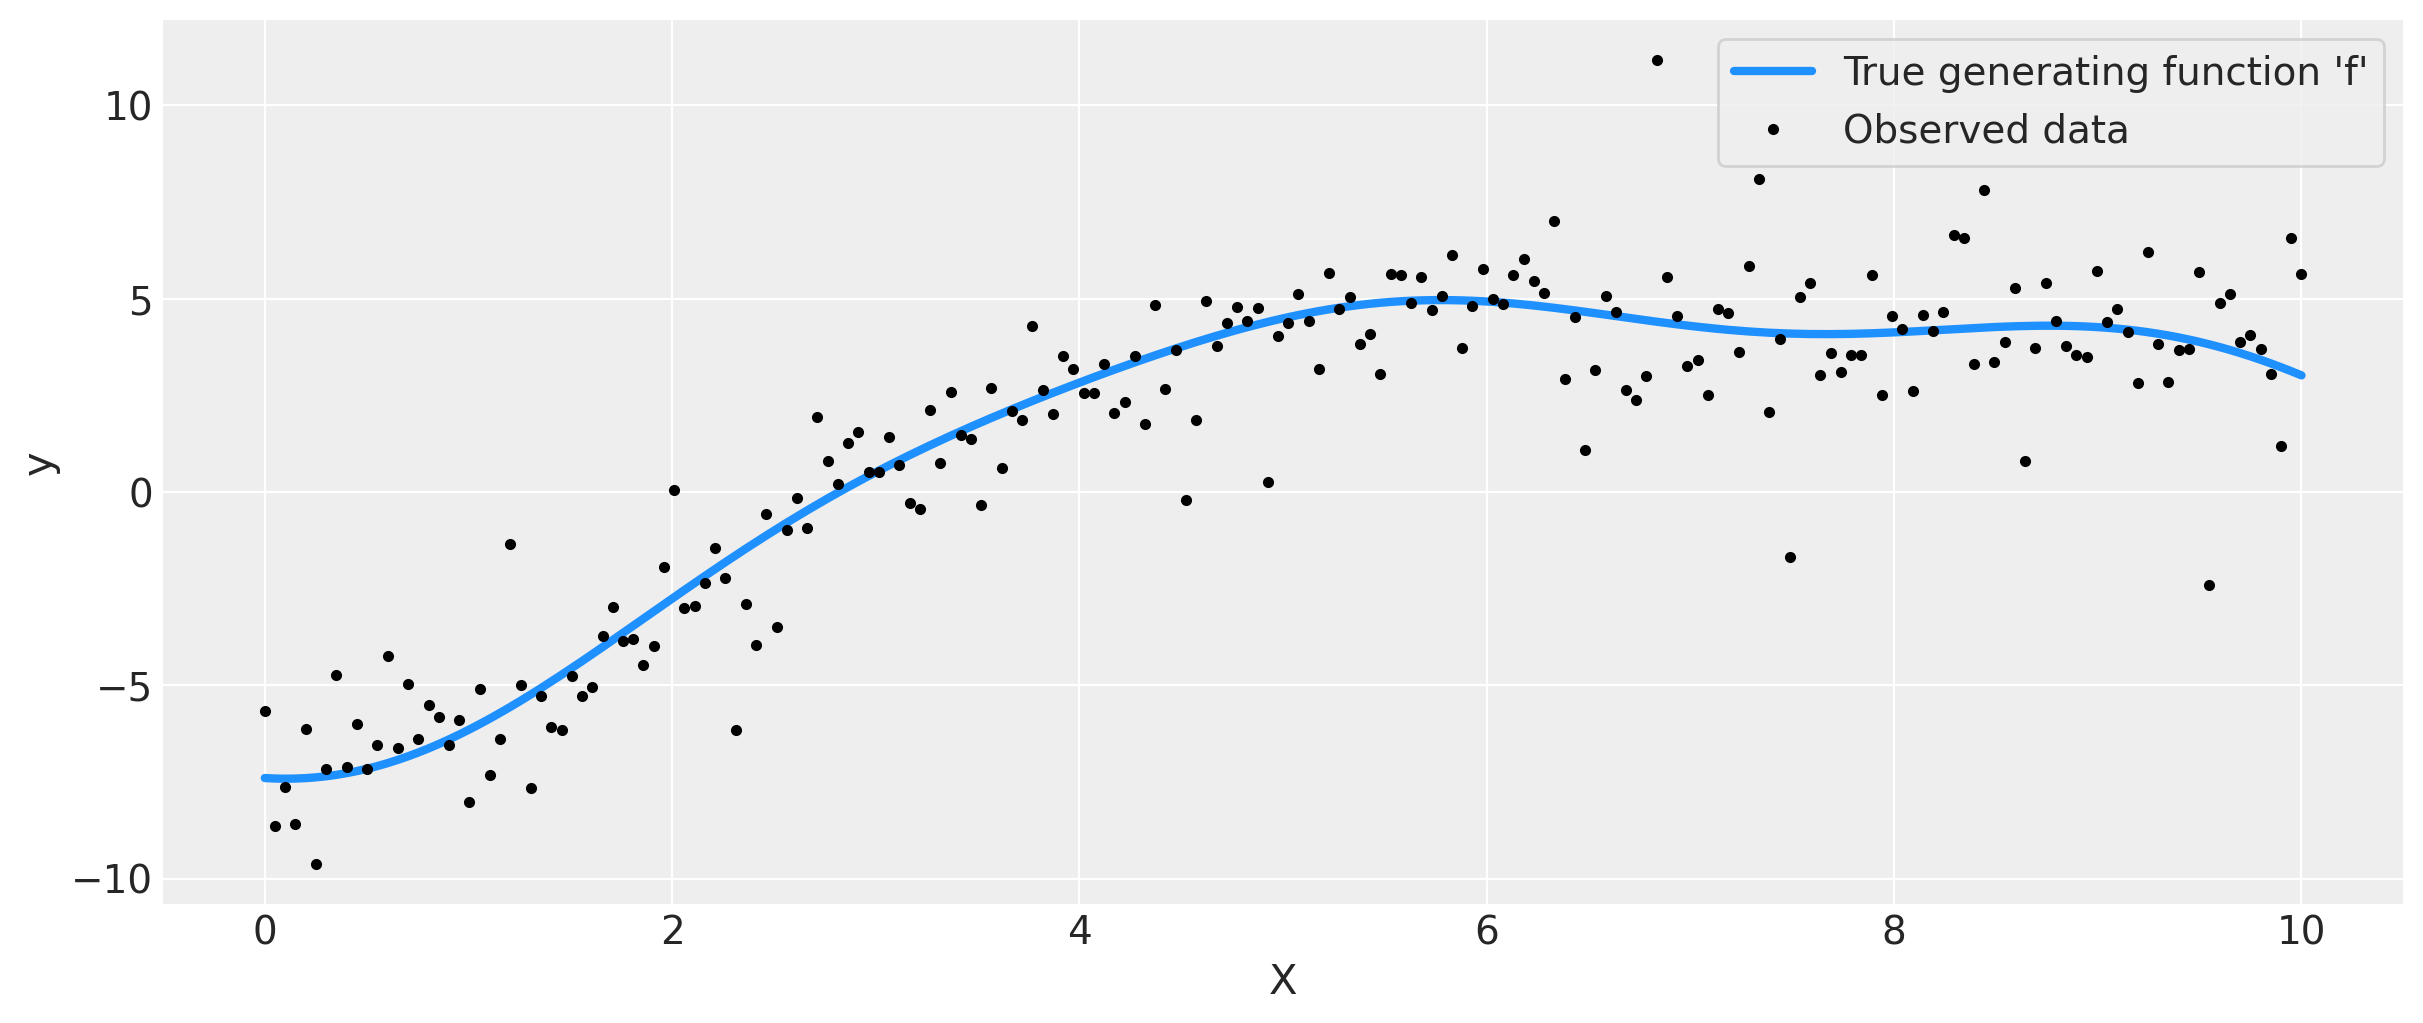

In [3]:
n = 200  # The number of data points
X = np.linspace(0, 10, n)[:, None]  # The inputs to the GP must be arranged as a column vector

# Define the true covariance function and its parameters
ell_true = 2.0
eta_true = 4.0
cov_func = eta_true ** 2 * pm.gp.cov.ExpQuad(1, ell_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = rng.multivariate_normal(
    mean_func(X).eval(), cov_func(X).eval() + 1e-8 * np.eye(n), 1
).flatten()

# The observed data is the latent function plus a small amount of T distributed noise
# The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
sigma_true = 1.0
nu_true = 3.0
y = f_true + sigma_true * rng.standard_t(nu_true, size=n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")
ax.set_xlabel("X")
ax.set_ylabel("y")
plt.legend(frameon=True);

The data above shows the observations, marked with black dots, of the unknown function $f(x)$ that has been corrupted by noise.  The true function is in blue.  

## Coding the model in PyMC3

Here's the model in PyMC3.  We use a $\text{Gamma}(\alpha = 2\,, \beta=1)$ prior over the lengthscale parameter, and weakly informative $\text{HalfNormal}(\sigma=5)$ priors over the covariance function scale, and noise scale.  A $\text{Gamma}(2, 0.1)$ prior is assigned to the degrees of freedom parameter of the noise.  Finally, a GP prior is placed on the unknown function.  For more information on choosing priors in Gaussian process models, check out some of [recommendations by the Stan folks](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations).

In [4]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=1)
    eta = pm.HalfNormal("eta", sd=5)

    cov = eta ** 2 * pm.gp.cov.ExpQuad(1, ell)
    gp = pm.gp.Latent(cov_func=cov)

    f = gp.prior("f", X=X)

    sigma = pm.HalfNormal("sigma", sd=5)
    nu = pm.Gamma("nu", alpha=2, beta=0.1)
    y_ = pm.StudentT("y", mu=f, lam=1.0 / sigma, nu=nu, observed=y)

    trace = pm.sample(1000, chains=2, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ell, eta, f_rotated_, sigma, nu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1082 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [5]:
# check Rhat, values above 1 may indicate convergence issues
n_nonconverged = int(
    np.sum(az.rhat(trace)[["eta", "ell", "sigma", "f_rotated_"]].to_array() > 1.03).values
)
print(f"The MCMC chains for {n_nonconverged} appear not to have converged.")

The MCMC chains for 0 appear not to have converged.


## Results

The joint posterior of the two covariance function hyperparameters is plotted below in the left panel.  In the right panel is the joint posterior of the standard deviation of the noise, and the degrees of freedom parameter of the likelihood.  The light blue lines show the true values that were used to draw the function from the GP.

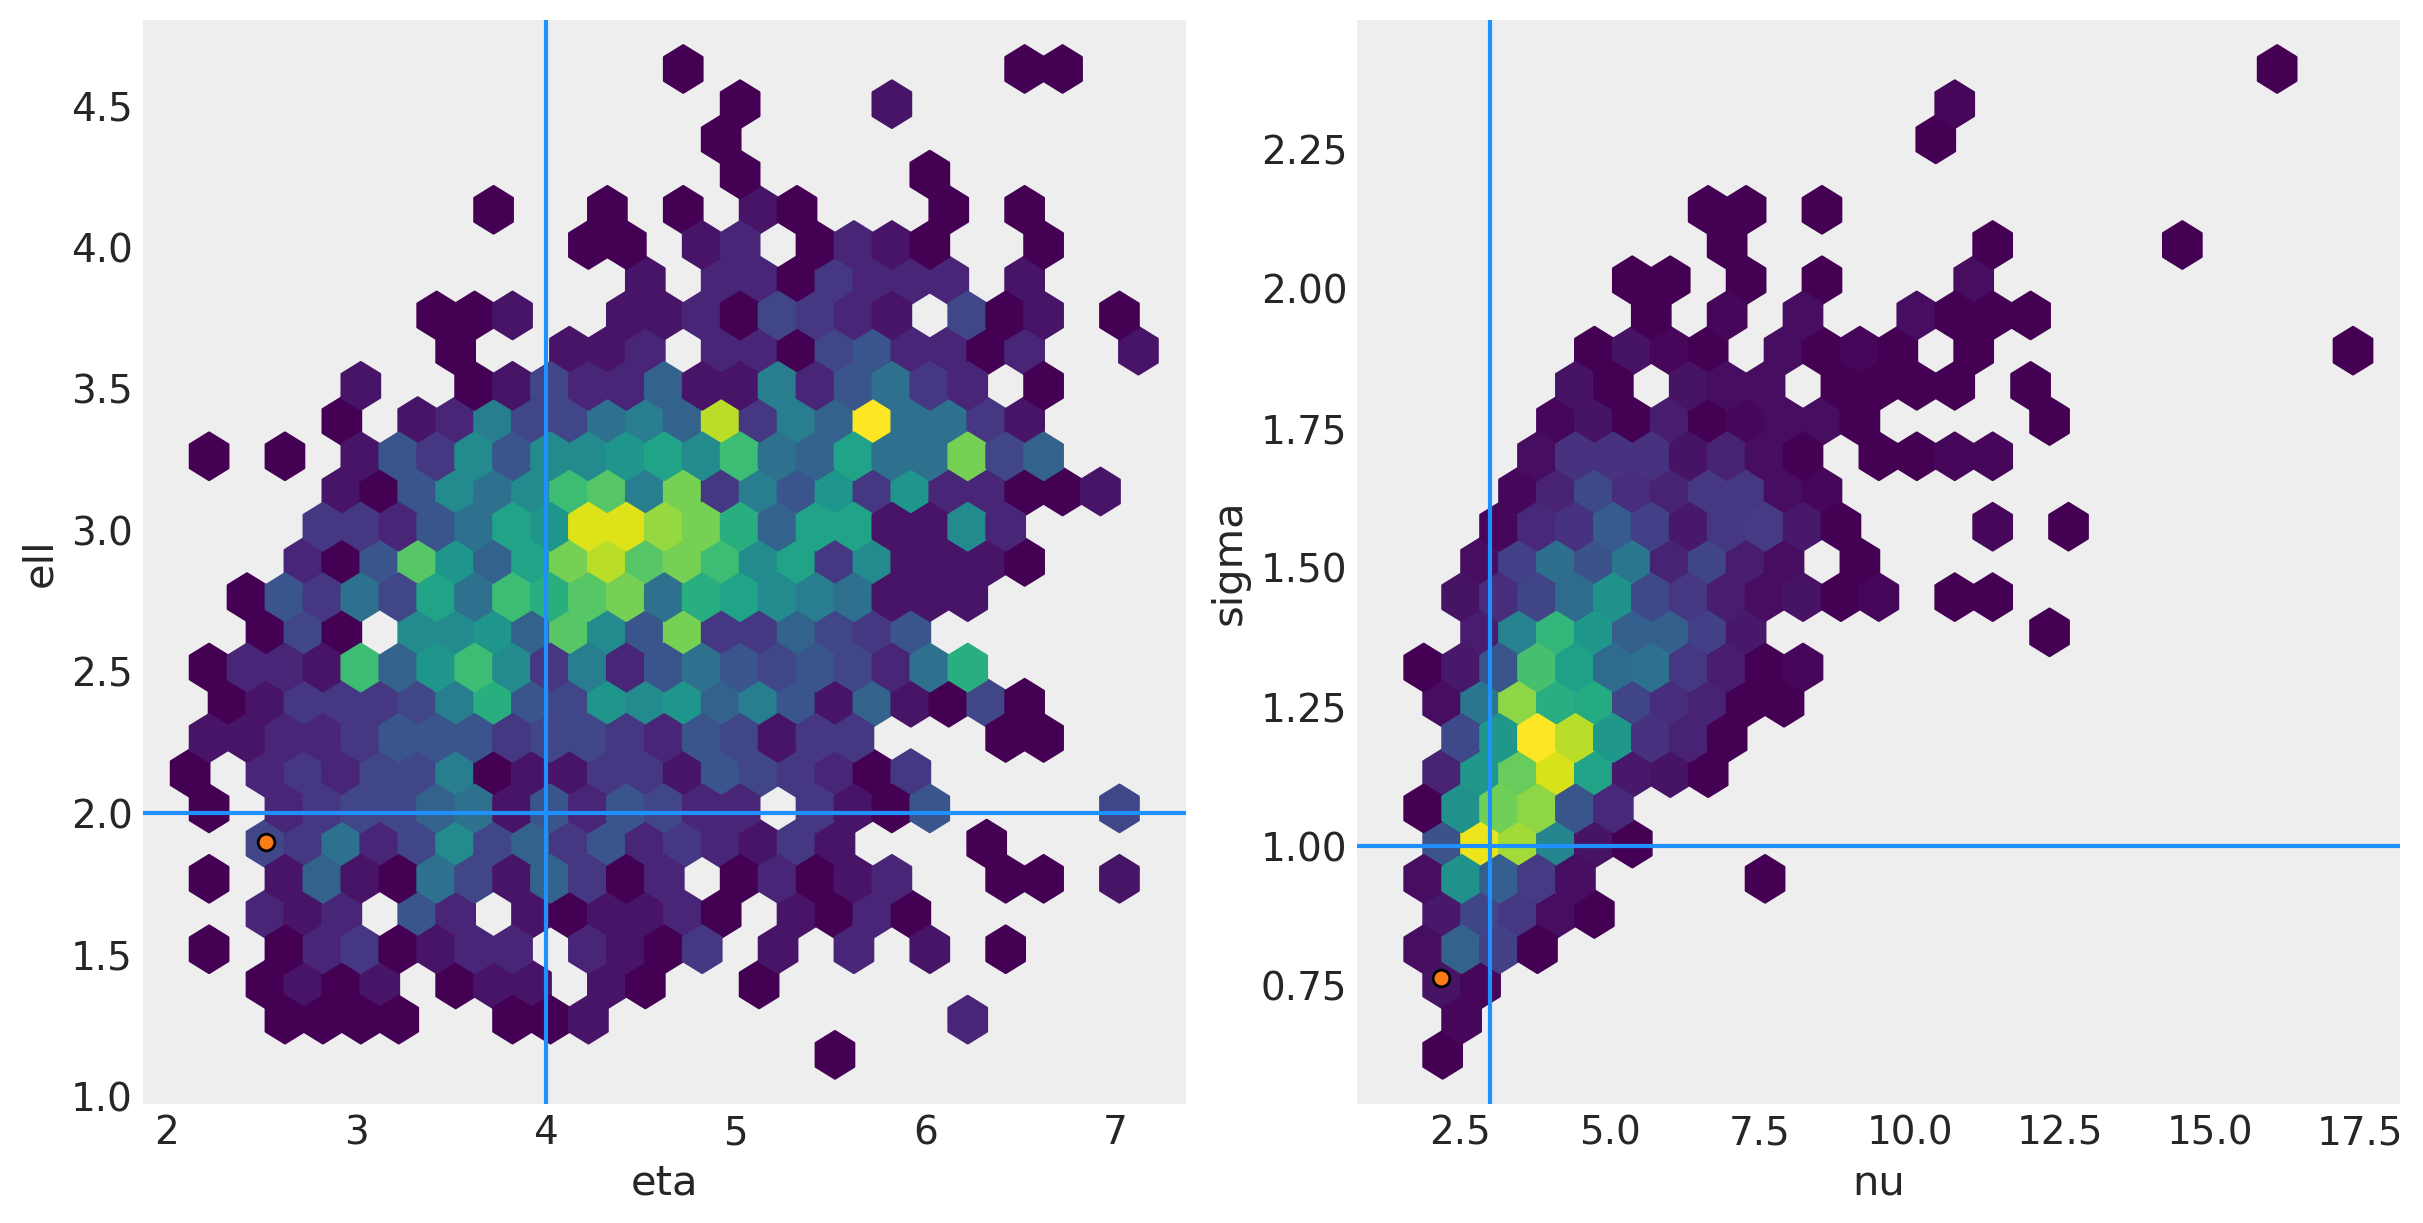

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs = axs.flatten()

# plot eta vs ell
az.plot_pair(
    trace,
    var_names=["eta", "ell"],
    kind=["hexbin"],
    ax=axs[0],
    gridsize=25,
    divergences=True,
)
axs[0].axvline(x=eta_true, color="dodgerblue")
axs[0].axhline(y=ell_true, color="dodgerblue")

# plot nu vs sigma
az.plot_pair(
    trace,
    var_names=["nu", "sigma"],
    kind=["hexbin"],
    ax=axs[1],
    gridsize=25,
    divergences=True,
)

axs[1].axvline(x=nu_true, color="dodgerblue")
axs[1].axhline(y=sigma_true, color="dodgerblue");

Below is the posterior of the GP, $f(x)$:

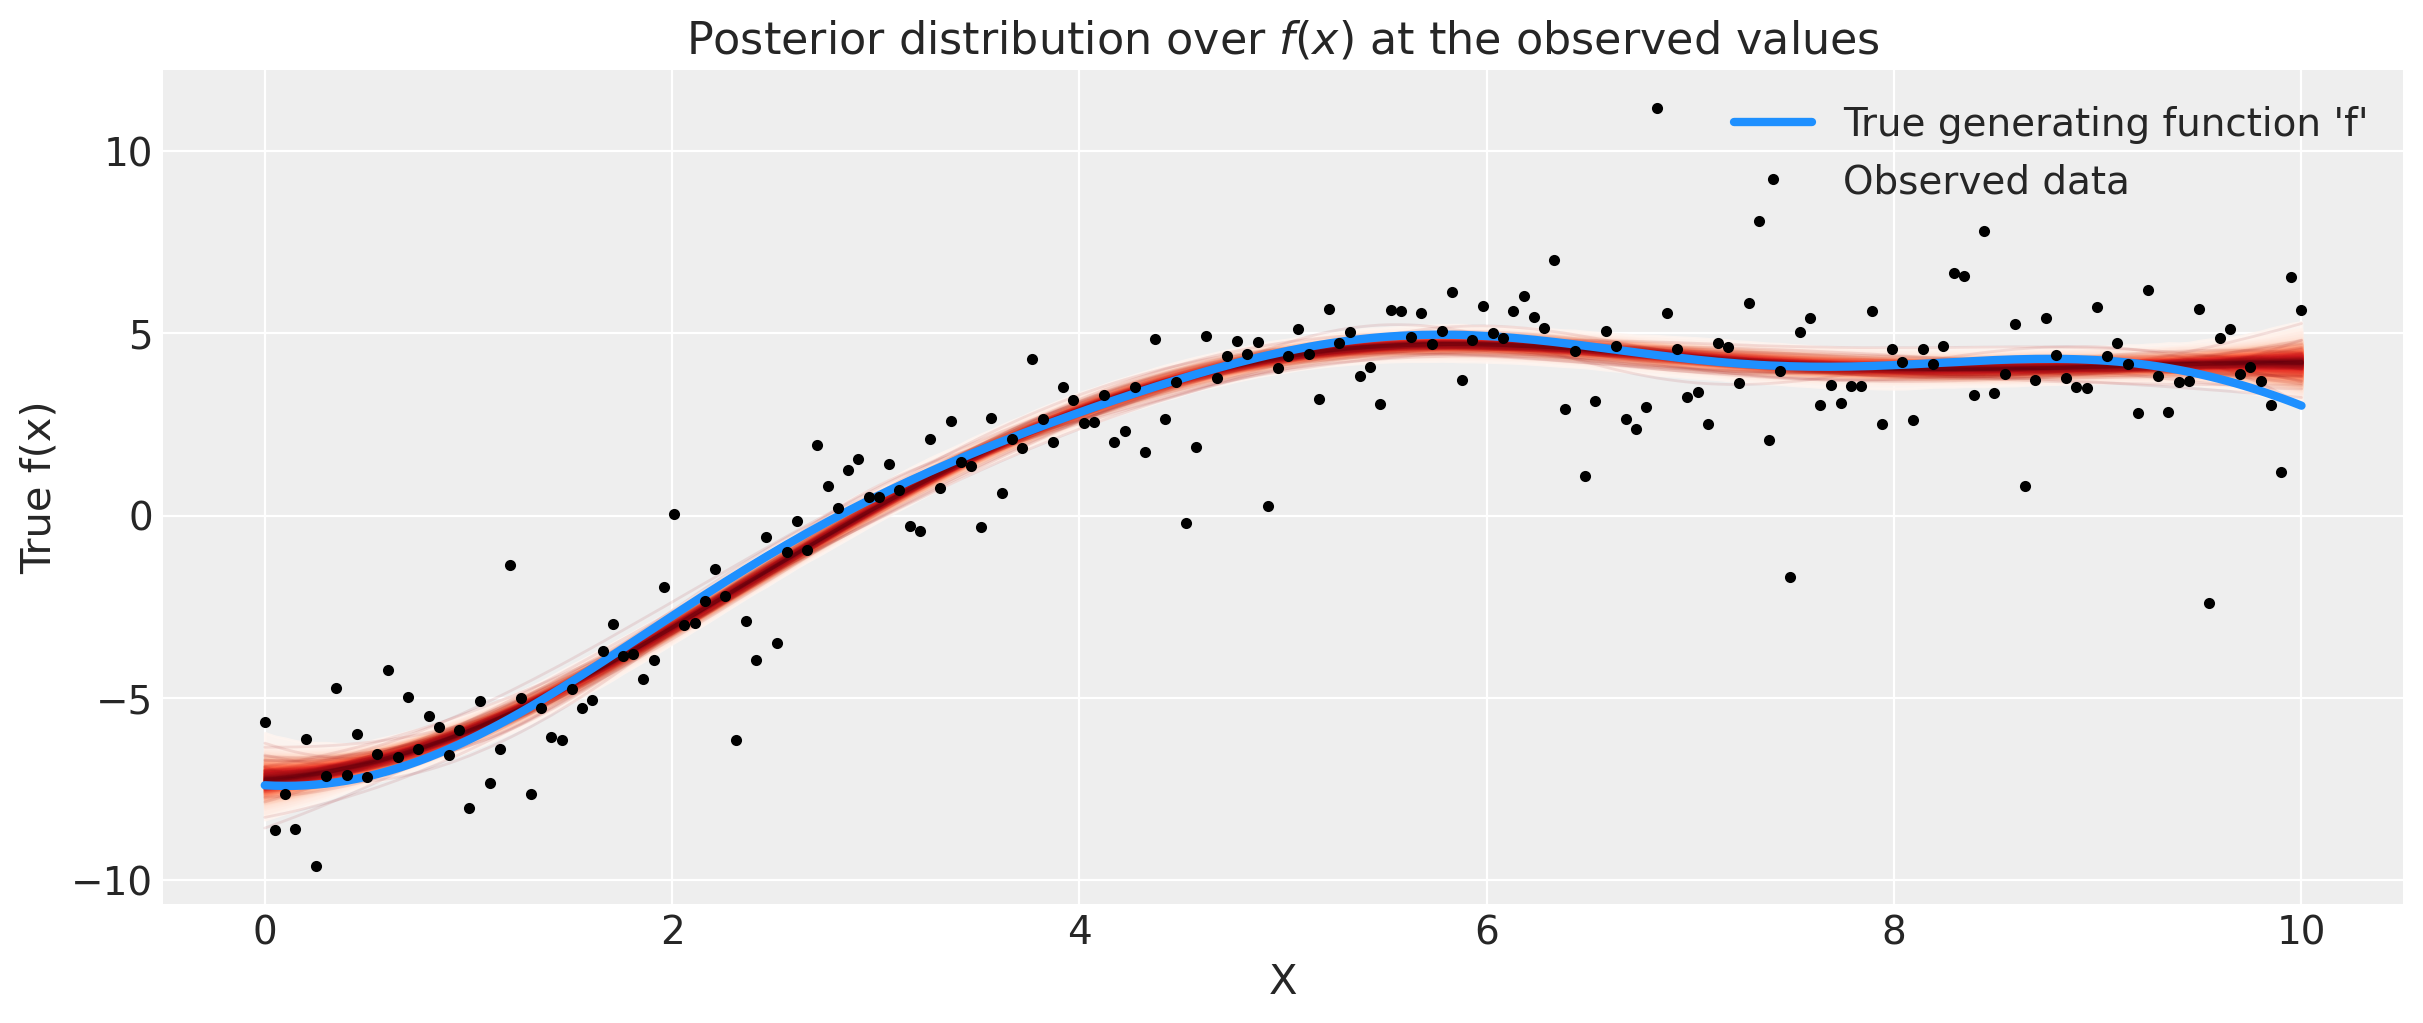

In [7]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["f"][0, :, :], X)

# plot the data and the true latent function
ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")

# axis labels and title
plt.xlabel("X")
plt.ylabel("True f(x)")
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

As you can see by the red shading, the posterior of the GP prior over the function does a great job of representing both the fit, and the uncertainty caused by the additive noise.  The result also doesn't over fit due to outliers from the Student-T noise model.

## Prediction using `.conditional`

Next, we extend the model by adding the conditional distribution so we can predict at new $x$ locations.  Lets see how the extrapolation looks out to higher $x$.  To do this, we extend our `model` with the `conditional` distribution of the GP.  Then, we can sample from it using the `trace` and the `sample_posterior_predictive` function.  This is similar to how Stan uses its `generated quantities {...}` blocks.  We could have included `gp.conditional` in the model *before* we did the NUTS sampling, but it is more efficient to separate these steps.

In [8]:
n_new = 200
X_new = np.linspace(-4, 14, n_new)[:, None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_posterior_predictive(trace.posterior, var_names=["f_pred"])

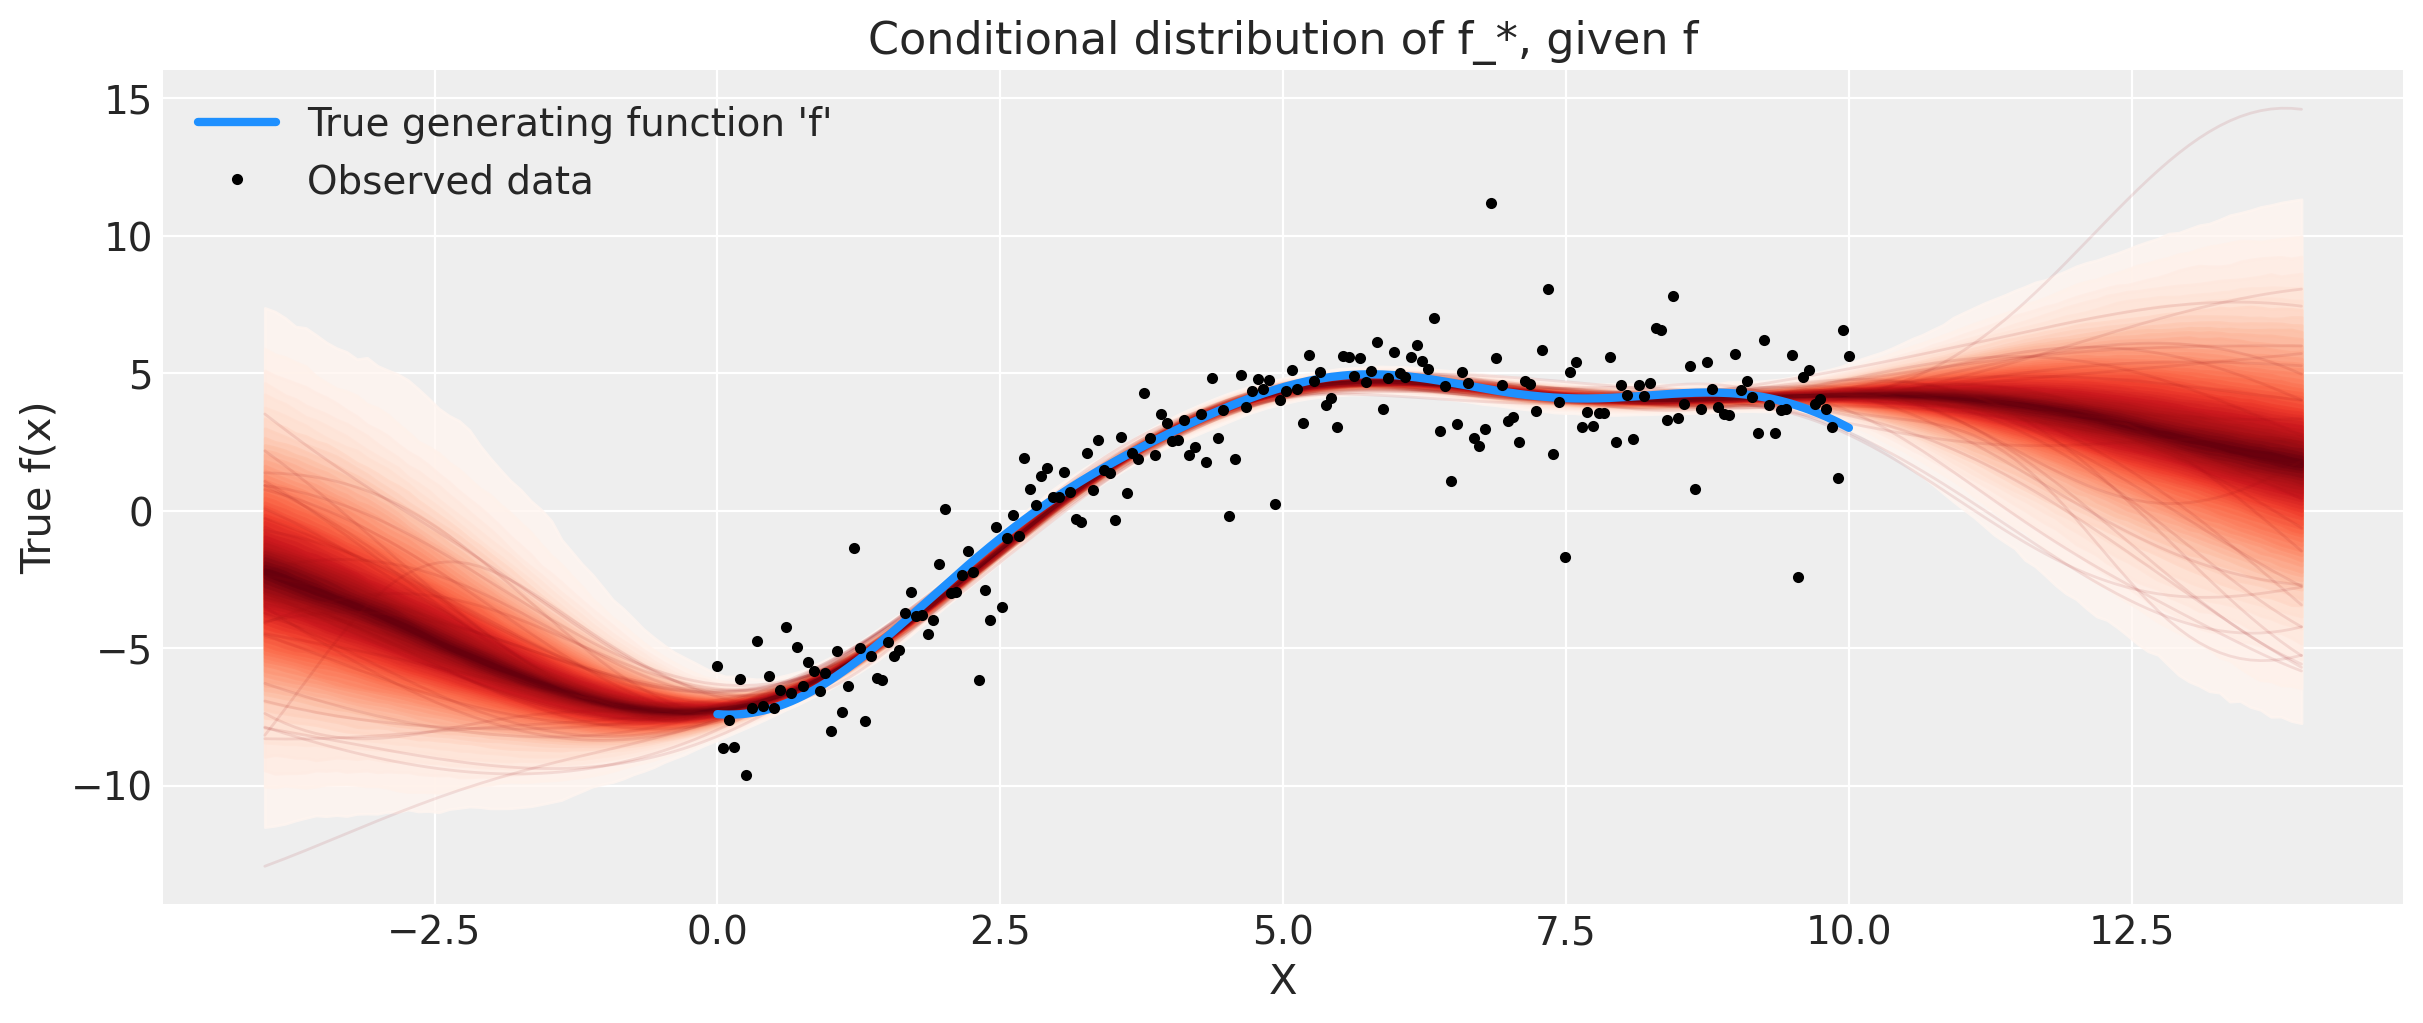

In [9]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_pred"], X_new)

ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")

ax.set_xlabel("X")
ax.set_ylabel("True f(x)")
ax.set_title("Conditional distribution of f_*, given f")
plt.legend();

## Example 2: Classification

First we use a GP to generate some data that follows a Bernoulli distribution, where $p$, the probability of a one instead of a zero is a function of $x$.  I reset the seed and added more fake data points, because it can be difficult for the model to discern variations around 0.5 with few observations.    

In [17]:
import sys

# reset the random seed for the new example
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

# number of data points
n = 400

# x locations
x = np.linspace(0, 1.5, n)

# true covariance
ell_true = 0.1
eta_true = 1.0
cov_func = eta_true ** 2 * pm.gp.cov.ExpQuad(1, ell_true)
K = cov_func(x[:, None]).eval()

# zero mean function
mean = np.zeros(n)

# sample from the gp prior
f_true = rng.multivariate_normal(mean, K + 1e-6 * np.eye(n), 1).flatten()

# link function
def invlogit(x, eps=sys.float_info.epsilon):
    return (1.0 + 2.0 * eps) / (1.0 + np.exp(-x)) + eps


y = pm.Bernoulli.dist(p=invlogit(f_true)).eval()

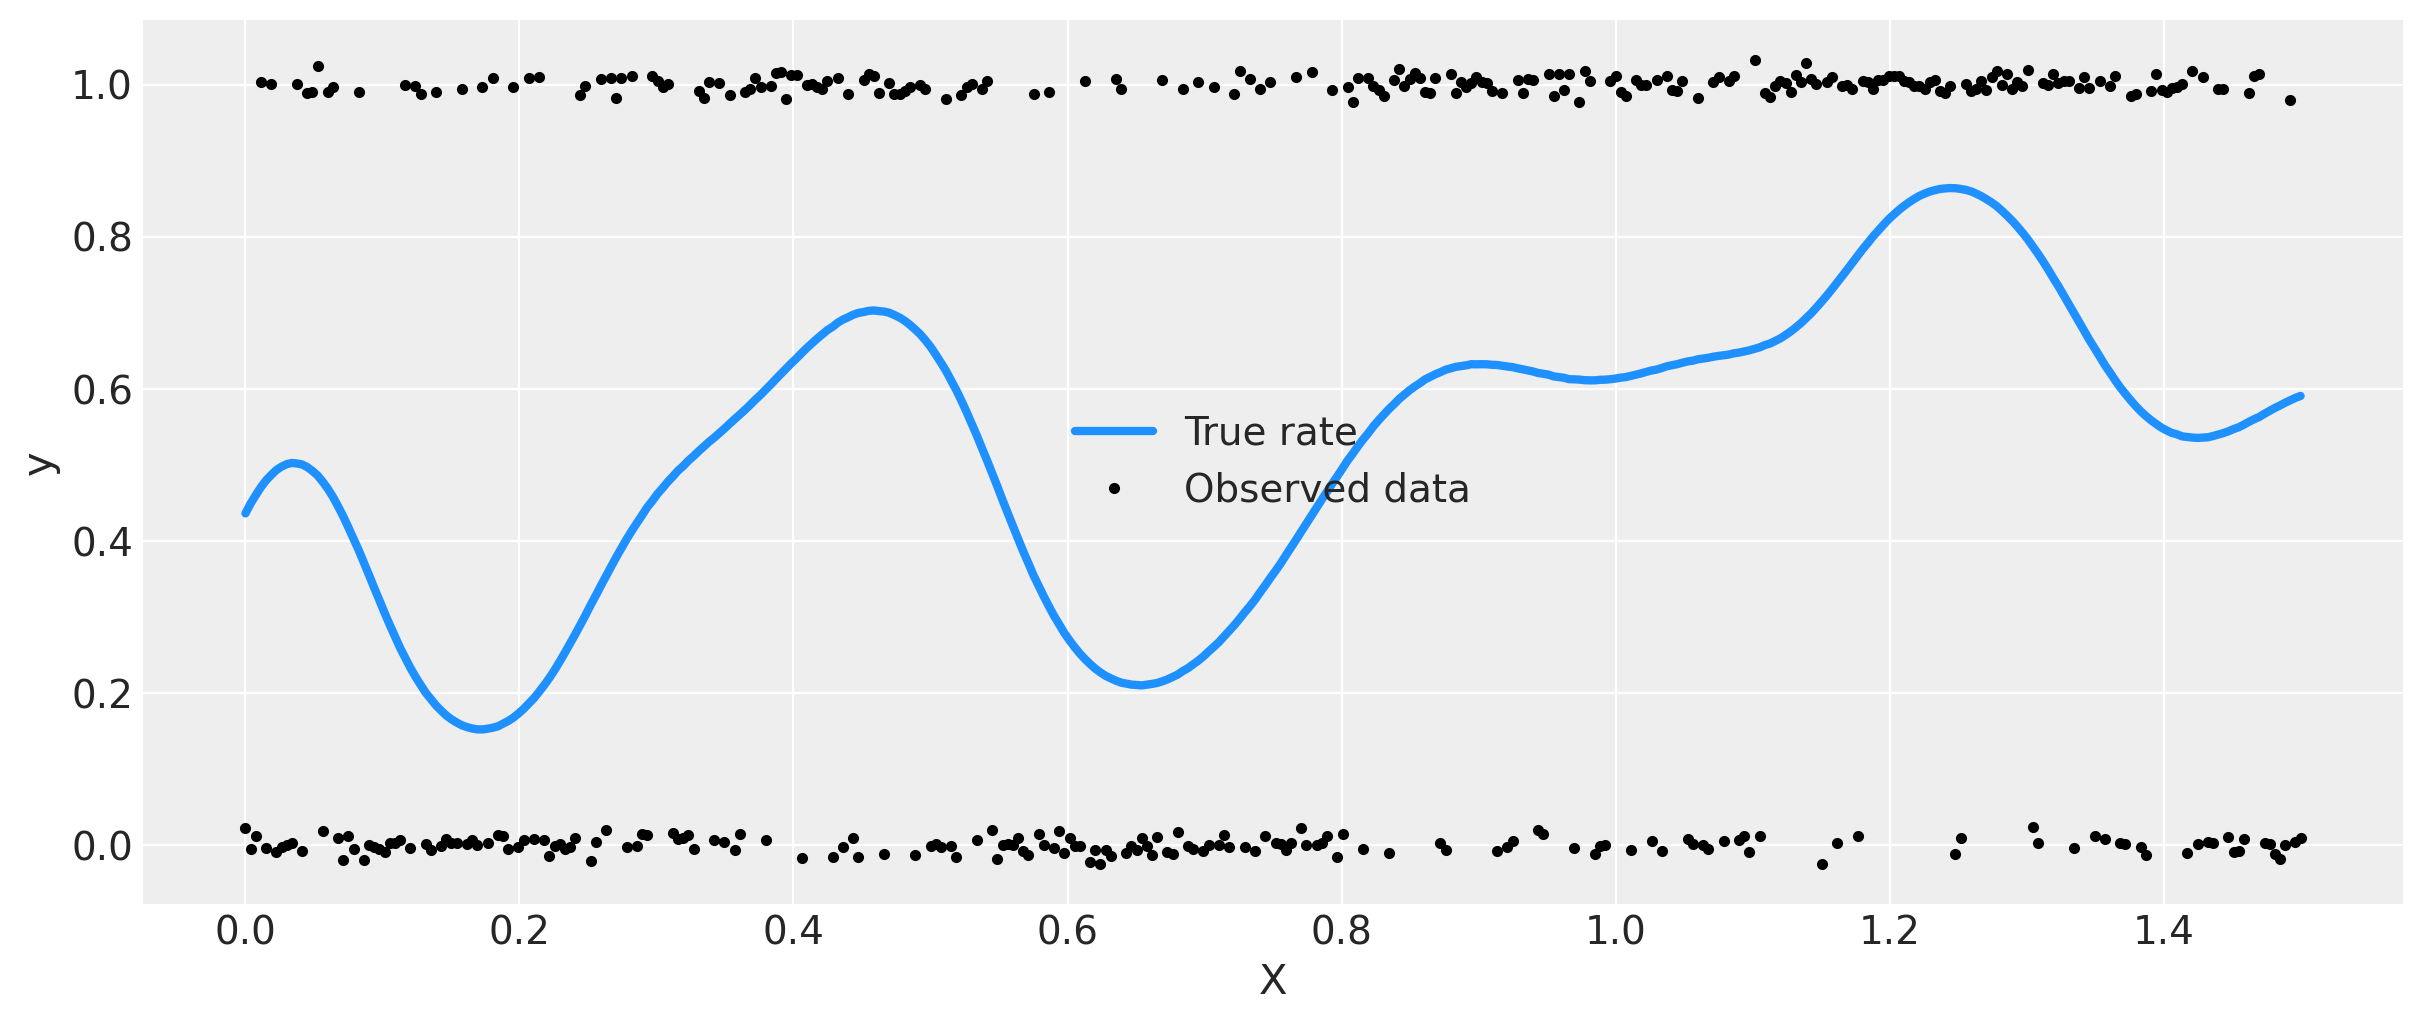

In [18]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

ax.plot(x, invlogit(f_true), "dodgerblue", lw=3, label="True rate")
# add some noise to y to make the points in the plot more visible
ax.plot(x, y + np.random.randn(n) * 0.01, "ko", ms=3, label="Observed data")

ax.set_xlabel("X")
ax.set_ylabel("y")
plt.legend();

In [19]:
with pm.Model() as model:
    # informative priors
    ell = pm.Gamma("ell", alpha=2, beta=2)
    eta = pm.HalfNormal("eta", sigma=1)
    cov = eta ** 2 * pm.gp.cov.ExpQuad(1, ell)

    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=x[:, None])

    # logit link and Bernoulli likelihood
    p = pm.Deterministic("p", pm.math.invlogit(f))
    y_ = pm.Bernoulli("y", p=p, observed=y)

    trace = pm.sample(1000, chains=2, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ell, eta, f_rotated_]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 760 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [20]:
# check Rhat
n_nonconverged = int(np.sum(az.rhat(trace)[["eta", "ell", "f_rotated_"]].to_array() > 1.03).values)
print("%i variables MCMC chains appear not to have converged." % n_nonconverged)

0 variables MCMC chains appear not to have converged.


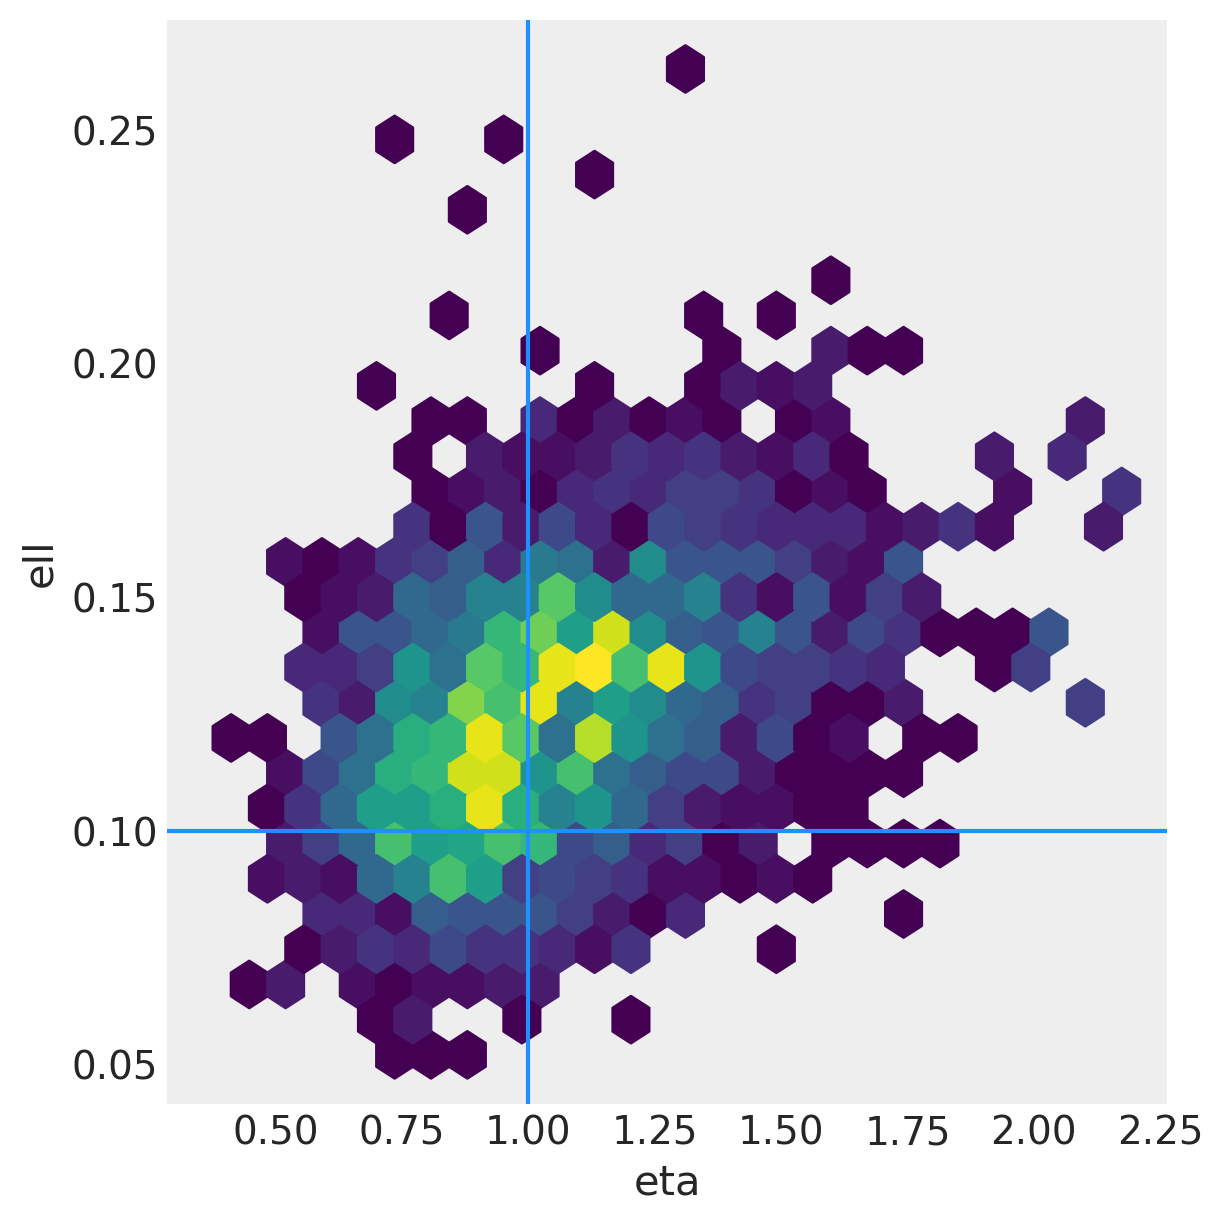

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

az.plot_pair(
    trace,
    var_names=["eta", "ell"],
    kind=["hexbin"],
    ax=ax,
    gridsize=25,
    divergences=True,
)

ax.axvline(x=eta_true, color="dodgerblue")
ax.axhline(y=ell_true, color="dodgerblue");

In [22]:
n_pred = 200
X_new = np.linspace(0, 2, n_pred)[:, None]

with model:
    f_pred2 = gp.conditional("f_pred", X_new)

with model:
    pred_samples = pm.sample_posterior_predictive(trace.posterior, var_names=["f_pred"])

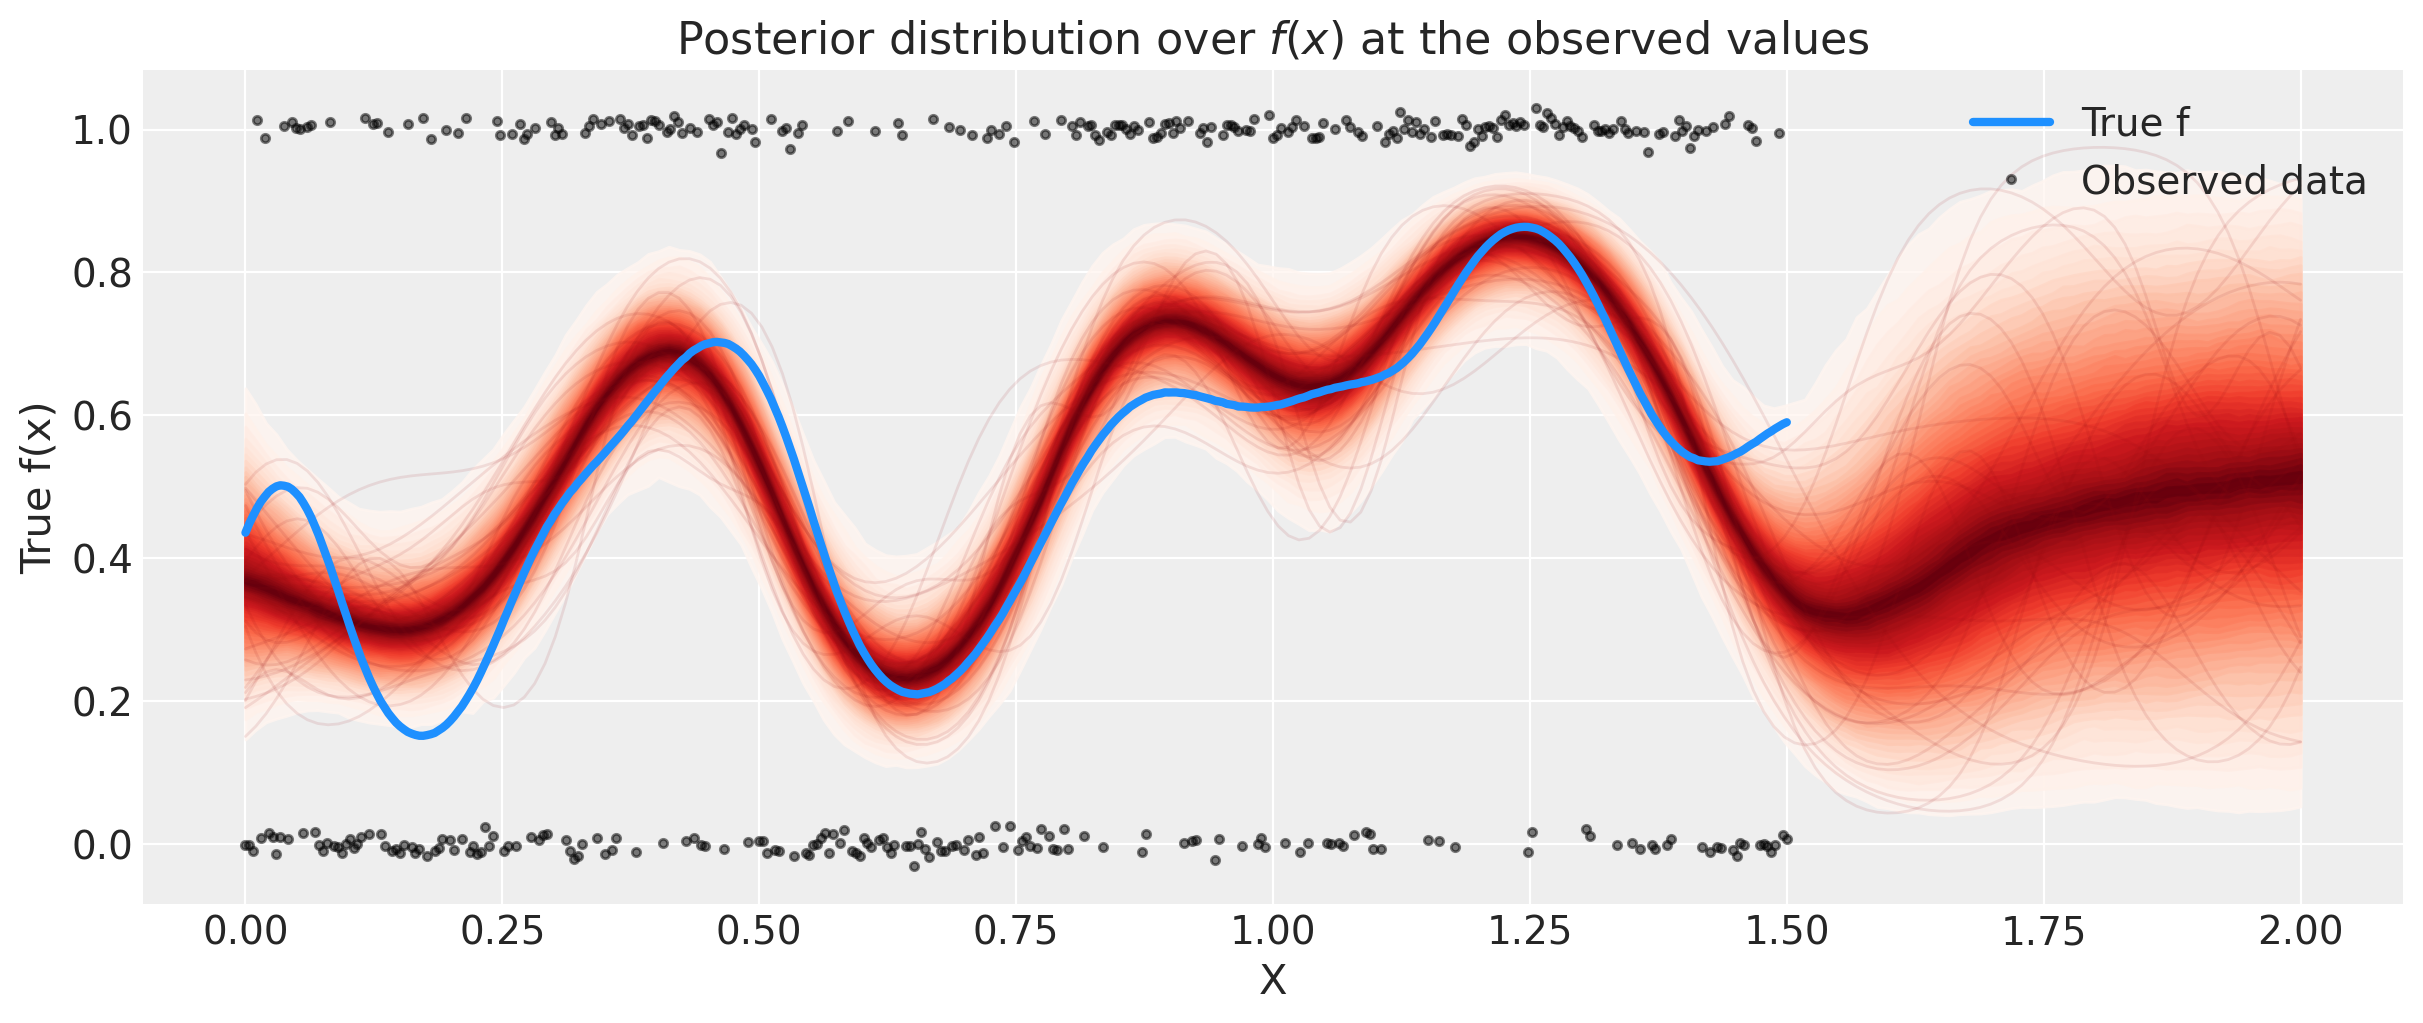

In [23]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, invlogit(pred_samples["f_pred"]), X_new)

# plot the data (with some jitter) and the true latent function
plt.plot(x, invlogit(f_true), "dodgerblue", lw=3, label="True f")
plt.plot(
    x,
    y + np.random.randn(y.shape[0]) * 0.01,
    "ok",
    ms=3,
    alpha=0.5,
    label="Observed data",
)

# axis labels and title
plt.xlabel("X")
plt.ylabel("True f(x)")
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend(loc="upper right");

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Oct 07 2021

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.27.0

sys       : 3.9.7 | packaged by conda-forge | (default, Sep  2 2021, 17:58:46) 
[Clang 11.1.0 ]
matplotlib: 3.4.3
arviz     : 0.11.2
aesara    : 2.2.2+10.ge51e87870
pymc      : 4.0.0
numpy     : 1.21.2

Watermark: 2.2.0

